In [1]:
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 53.7 MB 160 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
!pip install opencv-contrib-python==3.4.13.47 #--force-reinstall

Mounted at /content/drive


In [3]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import glob 

In [4]:
# creation of the output directory for the annotated frames and the raw_annotation data
%cd /content/drive/MyDrive/Colab Notebooks/darknet/doc_data
%mkdir output
%pwd
%cd /content/drive/MyDrive/Colab Notebooks/darknet/doc_data/test
%mkdir annotations

/content/drive/MyDrive/Colab Notebooks/darknet/doc_data
mkdir: cannot create directory ‘output’: File exists
/content/drive/MyDrive/Colab Notebooks/darknet/doc_data/test
mkdir: cannot create directory ‘annotations’: File exists


In [5]:
ROOT_COLAB = '/content/drive/MyDrive/Colab Notebooks/darknet'
YOLO_CONFIG = ROOT_COLAB + '/doc_data/'
COCO_LABELS_FILE = YOLO_CONFIG + 'document.names' # a file with the label the AI has to evaluate
YOLO_CONFIG_FILE = YOLO_CONFIG + 'yolov4_custom.cfg' # a config file for the darknet network
YOLO_WEIGHTS_FILE = YOLO_CONFIG + 'yolov4_custom_best.weights' # the weights file obtained after the training of the AI
LABELS_FROM_FILE = False
TEST_DIRECTORY = 'test/' # the directory for the videos used for A.I. test after training

VIDEO_DIRECTORY = 'video_test' # the directory with the frames of the video (in a jpg or png format) you need to evaluate
EXTENSION = '.jpg' # the extension of the frame format (either .jpg or .png)

OUTPUT_DIRECTORY = YOLO_CONFIG + 'output'

CONFIDENCE_MIN = 0.5

frames =[]
for filename in glob.glob(YOLO_CONFIG + TEST_DIRECTORY + VIDEO_DIRECTORY + '/*' + EXTENSION):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    frames.append(img)
fl = len(frames)
fl

4002

In [6]:
# Little function to resize in keeping the format ratio
# Cf. https://stackoverflow.com/questions/35180764/opencv-python-image-too-big-to-display
def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    image = image.copy()
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    return cv2.resize(image, dim, interpolation=inter)

In [7]:
with open(COCO_LABELS_FILE, 'rt') as f:
  labels = f.read().rstrip('\n').split('\n')

np.random.seed(45)
BOX_COLORS = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

In [8]:
yolo = cv2.dnn.readNetFromDarknet(YOLO_CONFIG_FILE, YOLO_WEIGHTS_FILE)

In [9]:
yololayers = [yolo.getLayerNames()[i[0] - 1] for i in yolo.getUnconnectedOutLayers()]

/content/drive/MyDrive/Colab Notebooks/darknet/doc_data/test/video_test/(2).jpg


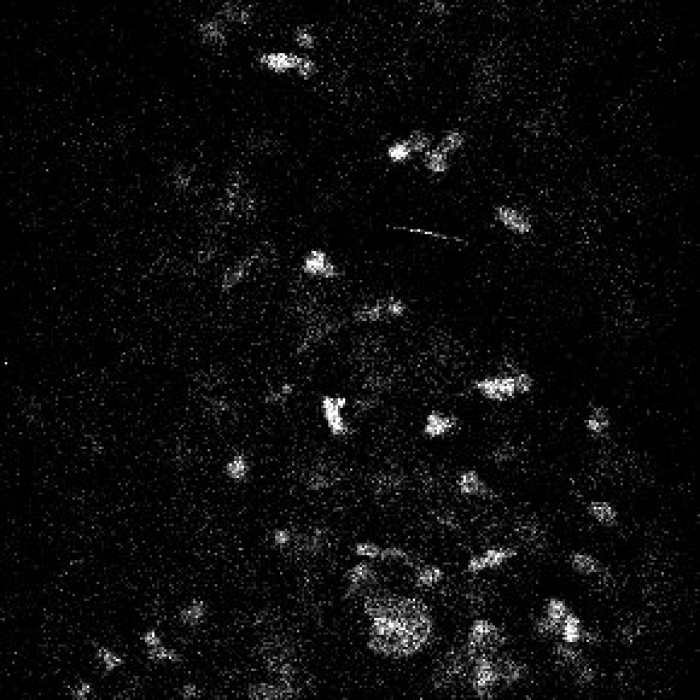

In [10]:
# This section was used for debug

# j=2
# print(YOLO_CONFIG + TEST_DIRECTORY + VIDEO_DIRECTORY + '/(%s)' % j + EXTENSION)
# IMAGE = cv2.imread(YOLO_CONFIG + TEST_DIRECTORY + VIDEO_DIRECTORY + '/(%s)' % j + EXTENSION)
# cv2_imshow(ResizeWithAspectRatio(IMAGE, width=700))

In [11]:
# a function that applies the yolo detection algorithm to one specific frame

def apply_yolo(j):
  
    # transform the image into a blob 
    print(YOLO_CONFIG + TEST_DIRECTORY + VIDEO_DIRECTORY + '/(%s)' % j + EXTENSION)
    IMAGE = cv2.imread(YOLO_CONFIG + TEST_DIRECTORY + VIDEO_DIRECTORY + '/(%s)' % j + EXTENSION)
    (H, W) = IMAGE.shape[:2]
    blobimage = cv2.dnn.blobFromImage(IMAGE, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    yolo.setInput(blobimage)

    layerOutputs = yolo.forward(yololayers)

    boxes_detected = []
    confidences_scores = []
    labels_detected = []

    # loop over each of the layer outputs
    for output in layerOutputs:
      # loop over each of the detections
      for detection in output:
        # extract the class ID and confidence (i.e., probability) of the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
 
        # Take only predictions with confidence more than CONFIDENCE_MIN thresold
        if confidence > CONFIDENCE_MIN:
         # Bounding box
          box = detection[0:4] * np.array([W, H, W, H])
          (centerX, centerY, width, height) = box.astype("int")
 
          # Use the center (x, y)-coordinates to derive the top and left corner of the bounding box
          x = int(centerX - (width / 2))
          y = int(centerY - (height / 2))
 
          # update our result list (detection)
          boxes_detected.append([x, y, int(width), int(height)])
          confidences_scores.append(float(confidence))
          labels_detected.append(classID)

    nb_results = len(boxes_detected)
    label_names = [labels[i] for i in labels_detected]
    final_boxes = cv2.dnn.NMSBoxes(boxes_detected, confidences_scores, 0.5, 0.5)

    image = IMAGE.copy()
    results =[]
    # loop through the final set of detections remaining after NMS and draw bounding box and write text
    for max_valueid in final_boxes:
      max_class_id = max_valueid[0]

      # extract the bounding box coordinates
      (x, y) = (boxes_detected[max_class_id][0], boxes_detected[max_class_id][1])
      (w, h) = (boxes_detected[max_class_id][2], boxes_detected[max_class_id][3])
      results.append([x, y, w, h])

      # draw a bounding box rectangle and label on the image
      color = [int(c) for c in BOX_COLORS[labels_detected[max_class_id]]]
      cv2.rectangle(image, (x, y), (x + w, y + h), color, 1)
    
      score = str(round(float(confidences_scores[max_class_id]) * 100, 1)) + "%"
      text = "{}: {}".format(labels[labels_detected[max_class_id]], score)
      cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # cv2_imshow(ResizeWithAspectRatio(image, width=700)) # uncomment this line if you want a display of the frames being annotated during worktime

    # save the image with the boxes and the text lines on it in the directory : /content/drive/MyDrive/Colab Notebooks/darknet/output as (1).jpg, (2).jpg,...
    cv2.imwrite(YOLO_CONFIG + 'output/frames' + '/(%s)_out.jpg' % j, image)
    results

    # select the output directory of the annotations .txt files
    %cd "/content/drive/MyDrive/Colab Notebooks/darknet/doc_data/output/annotations"

    filename = '%s_annotations.txt' % j
    with open(filename , 'w') as f:
      f.write('\n'.join(str(ele) for ele in results))
    f.close()

    return('Frame %s done' % j)

In [12]:
# apply the detection to all the frames
for i in range(len(frames)):
  apply_yolo(i+1)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
/content/drive/MyDrive/Colab Notebooks/darknet/doc_data/test/video_test/(1503).jpg
/content/drive/MyDrive/Colab Notebooks/darknet/doc_data/test/annotations
/content/drive/MyDrive/Colab Notebooks/darknet/doc_data/test/video_test/(1504).jpg
/content/drive/MyDrive/Colab Notebooks/darknet/doc_data/test/annotations
/content/drive/MyDrive/Colab Notebooks/darknet/doc_data/test/video_test/(1505).jpg
/content/drive/MyDrive/Colab Notebooks/darknet/doc_data/test/annotations
/content/drive/MyDrive/Colab Notebooks/darknet/doc_data/test/video_test/(1506).jpg
/content/drive/MyDrive/Colab Notebooks/darknet/doc_data/test/annotations
/content/drive/MyDrive/Colab Notebooks/darknet/doc_data/test/video_test/(1507).jpg
/content/drive/MyDrive/Colab Notebooks/darknet/doc_data/test/annotations
/content/drive/MyDrive/Colab Notebooks/darknet/doc_data/test/video_test/(1508).jpg
/content/drive/MyDrive/Colab Notebooks/darknet/doc_data/tes

In [13]:
# permenantly save the files in the different output directories
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
